In [1]:
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from metrics import Mask, prettyPrintTable, seriesAnalysis
from skimage import measure
from scipy.stats import cumfreq

Metric Functions Using: cuda


In [2]:
def show3D(matrix, size=(8, 8), downsample=1):
    matrix = matrix[::downsample, ::downsample, ::downsample]

    labels = np.unique(matrix)
    labels = labels[labels != 0]

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection="3d")

    for i, label in enumerate(labels):
        mask = (matrix == label).astype(np.uint8)

        if np.sum(mask) == 0:
            continue

        verts, faces, _, _ = measure.marching_cubes(mask, level=0)

        ax.plot_trisurf(
            verts[:, 0],
            verts[:, 1],
            faces,
            verts[:, 2],
            color=["blue", "orange"][i],
            linewidth=0,
            antialiased=True,
            alpha=0.9,
        )

    zdim, ydim, xdim = matrix.shape
    ax.set_xlim(0, zdim)
    ax.set_ylim(0, ydim)
    ax.set_zlim(0, xdim)
    ax.set_box_aspect(matrix.shape)

    plt.tight_layout()
    plt.show()

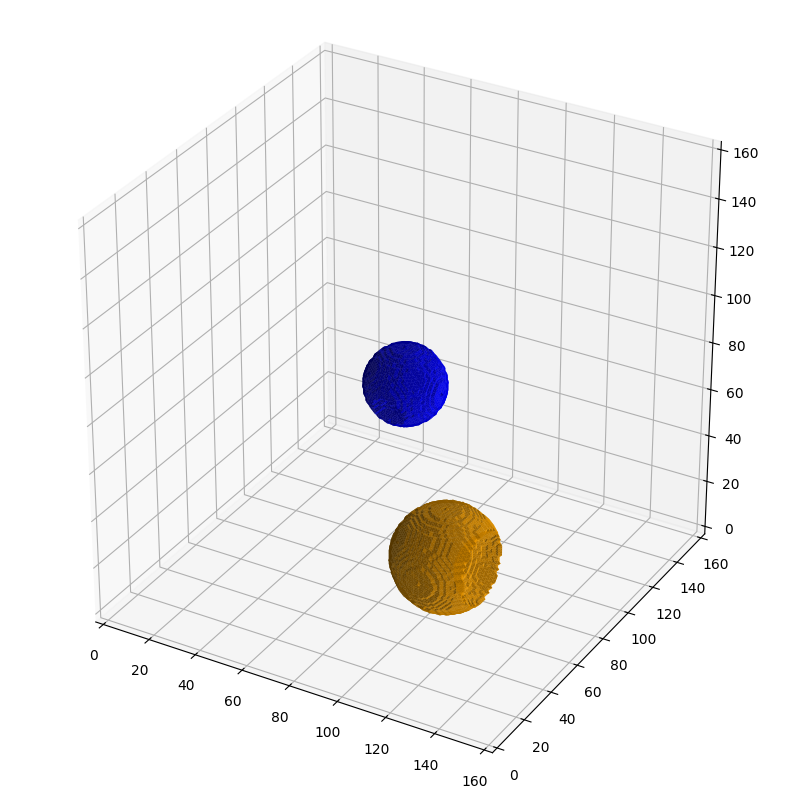

In [3]:
DIM = 160


def create_concave_sphere(radius, center, dentOffset, dentRadius, size=DIM):
    center = np.array(center)
    dentCenter = center + np.array(dentOffset)

    x, y, z = np.ogrid[:size, :size, :size]

    dist = (x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2
    dent = (x - dentCenter[0]) ** 2 + (y - dentCenter[1]) ** 2 + (z - dentCenter[2]) ** 2

    return (dist <= radius**2) & ~(dent <= dentRadius**2)


m0 = Mask(create_concave_sphere(15, (80, 80, 80), (0, -25, -10), 15))
m1 = Mask(create_concave_sphere(20, (120, 40, 40), (20, 0, 0), 15))

display = np.zeros((DIM, DIM, DIM))
display[np.where(m0.mask)] = 1
display[np.where(m1.mask)] = 2
show3D(display)

# Volumetric / Surface Area Analysis

In [4]:
print(f"M0 to M1 Volume Difference: {m0.getVolDiff(m1)}")
print(f"M0 to M1 Surface Area Difference: {m0.getSADiff(m1)}")

M0 to M1 Volume Difference: 14406
M0 to M1 Surface Area Difference: 1852


# Rigid Registration / Alignment Analysis

M1 to M0 Translation Vector: [ 37.69944603 -40.19016864 -40.07606746]
M1 to M0 Center of Mass Distance: 68.13654723568659


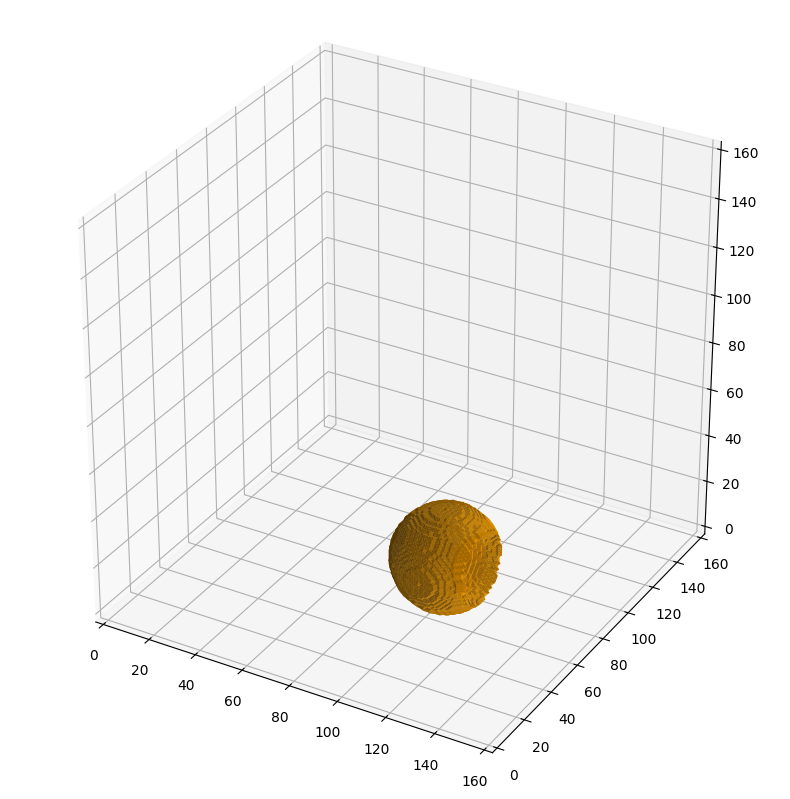

In [5]:
m1m0_transVec = m0.getTranslationVector(m1)
print(f"M1 to M0 Translation Vector: {m1m0_transVec}")
print(f"M1 to M0 Center of Mass Distance: {np.linalg.norm(m1m0_transVec)}")

m0_aligned = m0.rigidAlign(m1)

display = np.zeros((DIM, DIM, DIM))
display[np.where(m0_aligned.mask)] = 1
display[np.where(m1.mask)] = 2
show3D(display)

# Bi-directional Surface Discrepancy

In [6]:
bdsd, std, tsd = m0.bidirectionalSurfaceDiscrepancy(m1, bi_only=False)

bdsd_analysis, lbl = seriesAnalysis(bdsd, labels=True)
std_analysis = seriesAnalysis(std)
tsd_analysis = seriesAnalysis(tsd)

prettyPrintTable(
    [
        "Bi-directional Surface Discrepancy", 
        "Source to Target Surface Discrepancy", 
        "Target to Source Surface Discrepancy"
    ], [
        bdsd_analysis, 
        std_analysis, 
        tsd_analysis
    ], lbl)

+--------------------------------------+-----+-----+-------+-------+-------+-------+-------+-------+
|                                      | MIN | P05 | P10   | AVG   | MDN   | P90   | P95   | MAX   |
+--------------------------------------+-----+-----+-------+-------+-------+-------+-------+-------+
| Bi-directional Surface Discrepancy   | 0.0 | 0.0 | 0.0   | 2.871 | 3.464 | 5.745 | 6.164 | 8.062 |
+--------------------------------------+-----+-----+-------+-------+-------+-------+-------+-------+
| Source to Target Surface Discrepancy | 0.0 | 0.0 | 1.732 | 4.161 | 4.359 | 5.916 | 6.403 | 8.0   |
+--------------------------------------+-----+-----+-------+-------+-------+-------+-------+-------+
| Target to Source Surface Discrepancy | 0.0 | 0.0 | 0.0   | 0.525 | 0.0   | 2.236 | 4.243 | 8.062 |
+--------------------------------------+-----+-----+-------+-------+-------+-------+-------+-------+


# Margin Dilation Analysis

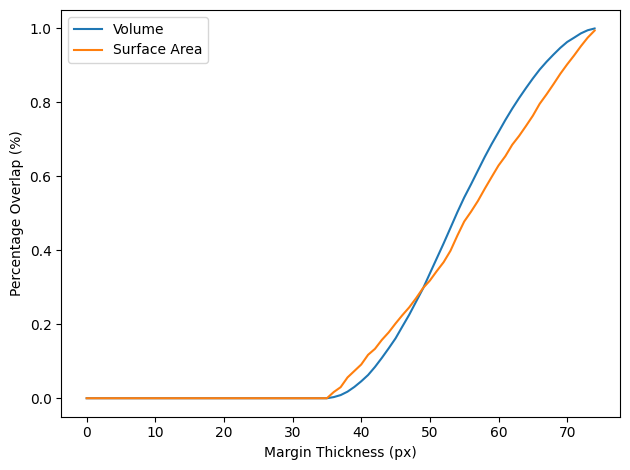

In [7]:
m0_sd = m1.maskDMap(m0)
m0_hsd = m1.maskDMap(m0.surface)

m1_sd = m0.maskDMap(m1)
m1_hsd = m0.maskDMap(m1.surface)

vol = []
sa = []
for i in range(np.ceil(np.max(m1_sd)).astype(int)):
    vol.append(np.sum(m1_sd < i) / m1.volume)
    sa.append(np.sum(m1_hsd < i) / m1.surface_area)

plt.plot(vol, label="Volume")
plt.plot(sa, label="Surface Area")
plt.legend()
plt.xlabel("Margin Thickness (px)")
plt.ylabel("Percentage Overlap (%)")
plt.tight_layout()

# Surface Distance Analysis

M0 RCV Surface Percentage: 61.008%
M1 RCV Surface Percentage: 47.107%



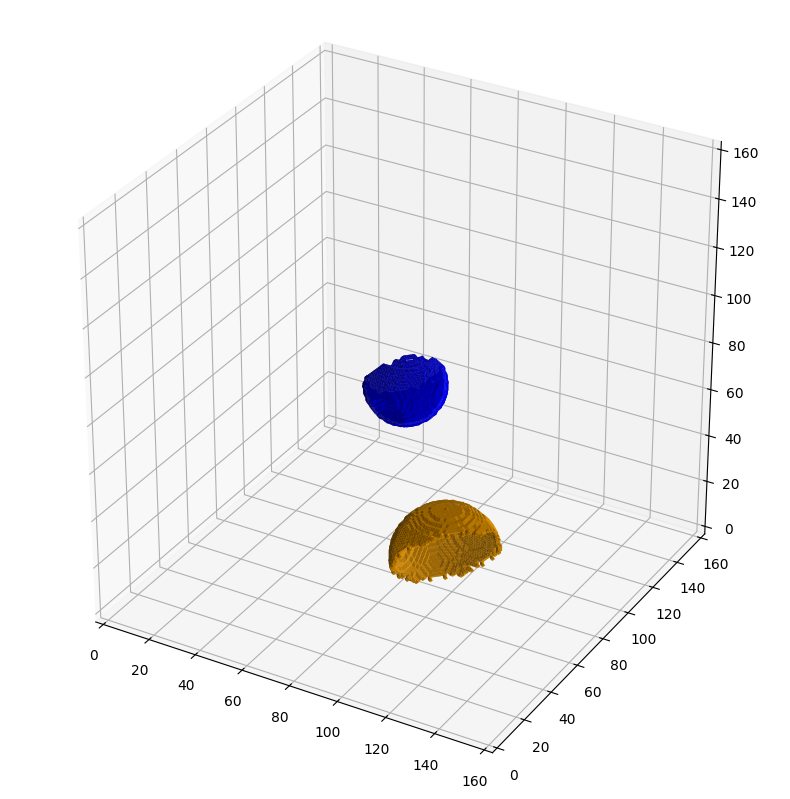

In [8]:
m0_rcvs = m0.getRayCastVisibleSurface(m1)
m1_rcvs = m1.getRayCastVisibleSurface(m0)

print(f"M0 RCV Surface Percentage: {(m0_rcvs.surface_area / m0.surface_area * 100):.3f}%")
print(f"M1 RCV Surface Percentage: {(m1_rcvs.surface_area / m1.surface_area * 100):.3f}%\n")

display = np.zeros((DIM, DIM, DIM))
display[np.where(m0_rcvs.mask)] = 1
display[np.where(m1_rcvs.mask)] = 2
show3D(display)

In [9]:
m0_rcvsd = m1.maskDMap(m0_rcvs)
m1_rcvsd = m0.maskDMap(m1_rcvs)

m0_sd_analysis, lbl = seriesAnalysis(m0_sd, labels=True)
m1_sd_analysis = seriesAnalysis(m1_sd)

m0_hsd_analysis = seriesAnalysis(m0_hsd)
m1_hsd_analysis = seriesAnalysis(m1_hsd)

m0_rcvsd_analysis = seriesAnalysis(m0_rcvsd)
m1_rcvsd_analysis = seriesAnalysis(m1_rcvsd)

prettyPrintTable(["M0 to M1 Surfaace Distance", "M1 to M0 Surface Distance"], [m0_sd_analysis, m1_sd_analysis], lbl)
prettyPrintTable(["M0 Surface to M1 Surfaace Distance", "M1 Surface to M0 Surface Distance"], [m0_hsd_analysis, m1_hsd_analysis], lbl)
prettyPrintTable(["M0 RCV Surface to M1 Surfaace Distance", "M1 RCV Surface to M0 Surface Distance"], [m0_rcvsd_analysis, m1_rcvsd_analysis], lbl)

+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
|                            | MIN    | P05    | P10    | AVG    | MDN    | P90    | P95    | MAX    |
+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
| M0 to M1 Surfaace Distance | 35.228 | 39.128 | 41.122 | 50.234 | 50.369 | 59.068 | 60.819 | 64.101 |
+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
| M1 to M0 Surface Distance  | 35.228 | 40.237 | 42.708 | 54.329 | 53.917 | 66.543 | 69.282 | 74.478 |
+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
+------------------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
|                                    | MIN    | P05    | P10    | AVG    | MDN    | P90    | P95    | MAX    |
+------------------------------------+--------+--------+-

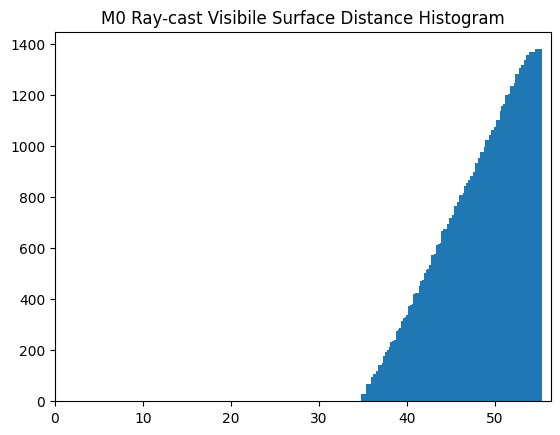

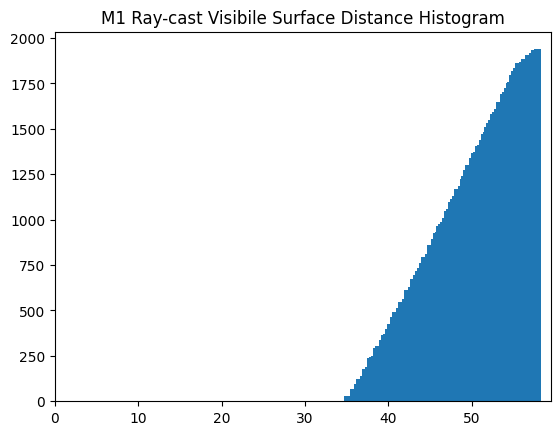

In [10]:
m0Res = cumfreq(m0_rcvsd, numbins=100)
m0X = m0Res.lowerlimit + np.linspace(0, m0Res.binsize * m0Res.cumcount.size, m0Res.cumcount.size)

m1Res = cumfreq(m1_rcvsd, numbins=100)
m1X = m1Res.lowerlimit + np.linspace(0, m1Res.binsize * m1Res.cumcount.size, m1Res.cumcount.size)

plt.figure()
plt.title("M0 Ray-cast Visibile Surface Distance Histogram")
plt.bar(m0X, m0Res.cumcount)
plt.xlim(0)
plt.show()

plt.figure()
plt.title("M1 Ray-cast Visibile Surface Distance Histogram")
plt.bar(m1X, m1Res.cumcount)
plt.xlim(0)
plt.show()